Import the modules for the analysis


In [1]:
from random import sample
from re import S, U
from turtle import update
import chaospy as cp
import sys
import os
sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
from scipy.constants import N_A
from scipy.constants import physical_constants
import numpy as np 
from tools.component_tools import Component, BreedingBlanket
from tools.component_tools import Fluid
from tools.component_tools import Membrane ,Geometry 
import tools.materials as materials
import matplotlib.pyplot as plt
import tools.correlations as corr
from scipy.constants import R
from turtle import color
import scipy.stats as stats

Define plot stile and font

In [2]:
plt.rcParams['font.family'] = 'serif'  # You can change 'serif' to any other font family you prefer
plt.rcParams['font.serif'] = ['Times New Roman']  # Specify the serif font
plt.rcParams['font.size'] = 24  # Set the font size
plt.rcParams['axes.titlesize'] = 32  # Title font size
plt.rcParams['axes.labelsize'] = 24  # Axis label font size
plt.rcParams['xtick.labelsize'] = 24  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 24  # Y-axis tick label font size
plt.rcParams['legend.fontsize'] = 24  # Legend font size
plt.rcParams['figure.titlesize'] = 32  # Figure title font size

In [3]:
Q=0.625E9 # fusion power in watts
TBR=1.08 # tritium breeding ratio
eV_to_J = physical_constants["electron volt-joule relationship"][0] # fr conversion of eV to J
reaction_energy = 17.6e6  # reaction energy in eV 17.6 MeV
neutrons = Q / (reaction_energy * eV_to_J) # number of neutrons per second
tritium_gen = TBR * neutrons / N_A #number of tritium moles generated per second
flag=0

In [4]:
def model_solver(PAV,HX,BB,c0,recirculation,flag_wc=0):
    n_pipes_HX=2000
    i=0
    err=1
    c_in=c0
    tol=1E-6
    while err>tol:
        i=i+1
        
        err2=1
        tol2=1E-6
        j=0
        while err2>tol2:
            j=j+1
            c_in1=c_in
            PAV.update_attribute("c_in",c_in)   
             ### update with correlations
            PAV.analytical_efficiency()
            PAV.update_attribute("eff",PAV.eff_an)
            PAV.outlet_c_comp()
            c_in=(PAV.c_out*recirculation+BB.c_out)/(recirculation+1)
            err2=abs((c_in-c_in1)/c_in)
        HX.update_attribute("c_in",PAV.c_out)
        HX.get_global_HX_coeff(0)
        L_HX=corr.get_length_HX(deltaTML=(corr.get_deltaTML(BB.T_out, BB.T_in,581, 800)), d_hyd=HX.fluid.d_Hyd, U=HX.U, Q=BB.Q/n_pipes_HX)
        HX.update_attribute("L",L_HX)
        HX.use_analytical_efficiency()
        HX.outlet_c_comp()
        
        err=abs((HX.c_out-BB.c_in)/HX.c_out)
        BB.update_attribute("c_in",HX.c_out)
        BB.get_cout()
    return 
def component_builder(samples, sample_str,flag_wc=0):
    d_hyd=25.4E-3
    T=900
    if "T" in sample_str:
        T=samples[sample_str.index("T")]
    L=20
    U0=1.5
    c0=1E-3
    mat=materials.Flibe(T)
    rho_flibe=2415.6-0.49072*T
    mu_flibe=1.16E-4*np.exp(3755/T)
    k_H=8.27E-9*np.exp(4.27E-3*T)
    D_flibe=9.3E-7*np.exp((-42E3)/(R*T))
    K_S_S=953*np.exp((-10.7E3)/(R*T))*1E-3
    k_b_const=8.617E-5
    D_S_PAV=5.6E-8*np.exp((-0.09)/(k_b_const*T))
    N_A_const=6.022E23
    K_S_PAV=8.31E22/N_A_const*np.exp((0.3)/(k_b_const*T))
    recirculation=0
    
    n_pipes_HX=2000
    flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=U0*(recirculation+1),k=mat.k,
        cp=mat.cp)
    Vanadium = Membrane( T=T,
            D=D_S_PAV,
            thick=0.5E-3,
            K_S=K_S_PAV,
            k_d=1E6,
            k_r=1E6,k=21)
    PAV_geometry=Geometry(D=d_hyd,L=L,thick=0.25E-3)
    c_in=c0
    BB=BreedingBlanket(Q=0.625E9,TBR=1.08,T_in=800,T_out=900,c_in=0, fluid=flibe)
    BB.get_flowrate()
    BB.get_cout()
    c0=BB.c_out
    PAV = Component(c_in=c_in,geometry=PAV_geometry, fluid=flibe, membrane=Vanadium)
    
        
    for i,sample in enumerate(samples):
        match sample_str[i]:
            case "D_L":
                PAV.fluid.update_attribute("D", sample)
            case "D_S":
                PAV.membrane.update_attribute("D", sample * np.exp((-0.09) / (k_b_const * T)))
            case "U0":
                PAV.fluid.update_attribute("U0", sample * (recirculation + 1))
            case "corr":
                PAV.fluid.get_kt()
                PAV.fluid.update_attribute("k_t", sample * PAV.fluid.k_t * sample)
            case "K_S_S":
                PAV.membrane.update_attribute("K_S", sample*np.exp((0.3)/(k_b_const*T)))
            case _:
                PAV.update_attribute(sample_str[i],sample)
    if flag_wc==1: 
        PAV.get_adimensionals()
        Re = corr.Re(rho=PAV.fluid.rho, u=PAV.fluid.U0, L=PAV.fluid.d_Hyd, mu=PAV.fluid.mu)
        Sc = corr.Schmidt(D=PAV.fluid.D, mu=PAV.fluid.mu, rho=PAV.fluid.rho)
        Sh_wc=0.132*Re**0.72*Sc**0.37*(3)**-0.372
        k_t_wc=corr.get_k_from_Sh(Sh_wc, L=PAV.fluid.d_Hyd,
                    D=PAV.fluid.D,)
        PAV.update_attribute("k_t",k_t_wc)
    mat_HX=materials.Flibe((BB.T_in+BB.T_out)/2)
    D_Steel=4.17E-8*np.exp((-0.12)/(8.617E-5*T))
    Steel_HX = Membrane( T=T,
            D=D_Steel,
            thick=1E-3,
            K_S=K_S_S,
            k_d=1E6,
            k_r=1E6,k=21)
    d_hyd_HX=50E-3
    U0_HX=BB.m_coolant/(mat_HX.rho*np.pi*d_hyd_HX**2/4*n_pipes_HX)
    flibe_HX=Fluid(T=(BB.T_in+BB.T_out)/2, Solubility=mat_HX.Solubility, MS=True,D=mat_HX.D, d_Hyd=d_hyd_HX ,mu=mat_HX.mu,U0=U0_HX,rho=mat_HX.rho,k=mat.k,cp=mat_HX.cp)
    geometry_HX=Geometry(D=d_hyd_HX,L=L,thick=1E-3)
    HX = Component(c_in=c_in,geometry=geometry_HX, fluid=flibe_HX, membrane=Steel_HX)
    n_pipes_HX=BB.m_coolant/(mat_HX.rho*np.pi*d_hyd_HX**2/4*HX.fluid.U0)
    model_solver(PAV,HX,BB,c0,recirculation,flag_wc)
    return PAV.eff

Define confidence interval for the gaussian

In [5]:

confidence_level = 0.80 # 90 % of samples are within 
percentage_within_mean = 0.15 # the 10% of the mean
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
confidence_level_corr = 0.80
percentage_within_mean_corr = 0.15 # 15% of the mean
# Find the z-score for the given confidence level
z_score_corr = stats.norm.ppf(1 - (1 - confidence_level_corr) / 2)


Define the Probability density functions

In [6]:
N=4E3 # number of evaluations
# Define mean values for the uncertain variables
T_mean=900
U0_mean=1.75
L_mean=20
d_hyd_mean=2.54E-2
k_H_mean=8.27E-9*np.exp(4.27E-3*T_mean)
D_flibe_mean=9.3E-7*np.exp((-42E3)/(R*T_mean))
corr_correction_mean=1
thick_mean=1E-3
N_A_const=6.022E23
K_S_mean=8.31E22/N_A_const
D_S_0_mean=7.43E-7
# define probability distributions for the uncertain variables
T=cp.Normal(mu=T_mean,sigma=percentage_within_mean * 300 / z_score)
# U0=cp.Normal(mu=U0_mean,sigma=percentage_within_mean * U0_mean / z_score)
U0=cp.Uniform(1,2.5)
# L=cp.Normal(mu=L_mean,sigma=percentage_within_mean * L_mean / z_score)
L=cp.Uniform(15,25)
d_hyd=cp.Uniform(2.54E-2/2,5.08E-2)
# k_H = cp.Normal(mu=k_H_mean, sigma=(percentage_within_mean *k_H_mean / z_score))
k_H=10**cp.Uniform(-4,0)
D_flibe=10**(cp.Uniform(-10,-7))
# D_flibe=cp.Normal(mu=D_flibe_mean, sigma=(percentage_within_mean * D_flibe_mean / z_score))
corr_correction=cp.Normal(mu=corr_correction_mean,sigma=percentage_within_mean_corr * corr_correction_mean / z_score_corr)
# thick=cp.Normal(mu=thick_mean,sigma=percentage_within_mean * thick_mean / z_score)
thick=cp.Uniform(thick_mean/2,thick_mean*2)
K_S=cp.Normal(mu=K_S_mean,sigma=percentage_within_mean * K_S_mean / z_score)
#Solubility vanadium
D_S_0=10**(cp.Uniform(-10,-7))
K_S_S=10**(cp.Uniform(-4,0))
# D_S_0=cp.Normal(mu=D_S_0_mean,sigma=percentage_within_mean * D_S_0_mean / z_score)
# K_S_S=cp.Normal(mu=K_S_mean,sigma=percentage_within_mean * K_S_mean / z_score)


Run the sensitivity analysis


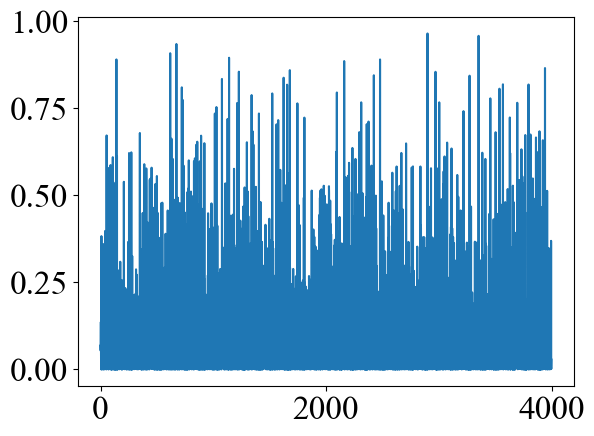

In [7]:
joint=cp.J(T,U0,L,d_hyd,k_H,D_flibe,corr_correction,thick,D_S_0,K_S_S)
expansion=cp.generate_expansion(4,joint)
samples=joint.sample(N,rule="sobol")
sample_str=["T","U0","L","d_Hyd","Solubility","D_L","corr","thick","D_S","K_S_S"]
title_str=["Temperature","Velocity","Length","Hydraulic Diameter","Solubility","Diffusivity","Correlation","Thickness","Diffusivity Solid","Solubility Solid"]
axis_str = [
    r"$\text{Temperature (K)}$",
    r"$\text{Velocity (m/s)}$",
    r"$\text{Length (m)}$",
    r"$\text{Hydraulic Diameter (m)}$",
    r"$\text{Solubility}$",
    r"$\text{Diffusivity (m}^2\text{/s)}$",
    r"$\text{Correlation (-)}$",
    r"$\text{Thickness (m)}$",
    r"$\text{Diffusivity Solid (m}^2\text{/s)}$",
    r"$\text{Solubility Solid}$"
]
colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Yellow-green
    "#17becf",   # Cyan
    "#ff1493",  # Deep Pink
    "#00ff00"   # Lime
]
import matplotlib.colors as mcolors

def lighten_color(color, amount=0.4):
    """
    Lightens the given color by mixing it with white.
    
    Parameters:
    color (str): The hex color string (e.g., "#1f77b4").
    amount (float): The amount to lighten the color (0 to 1).
    
    Returns:
    str: The lightened color as a hex string.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgb(c)
    white = np.array([1, 1, 1])
    c = np.array(c)
    new_color = c + (white - c) * amount
    return mcolors.to_hex(new_color)



color_wc = [lighten_color(color, amount=0.2) for color in colors]
flag=1
evaluations = np.array([component_builder(sample,sample_str) for sample in samples.T])
evaluations_wc=np.array([component_builder(sample,sample_str,1) for sample in samples.T])
plt.plot(evaluations.T)
# approx_solver=cp.fit_regression(expansion,samples,evaluations)
# approx_solver_wc=cp.fit_regression(expansion,samples,evaluations_wc)


Plot Evaluations on samples

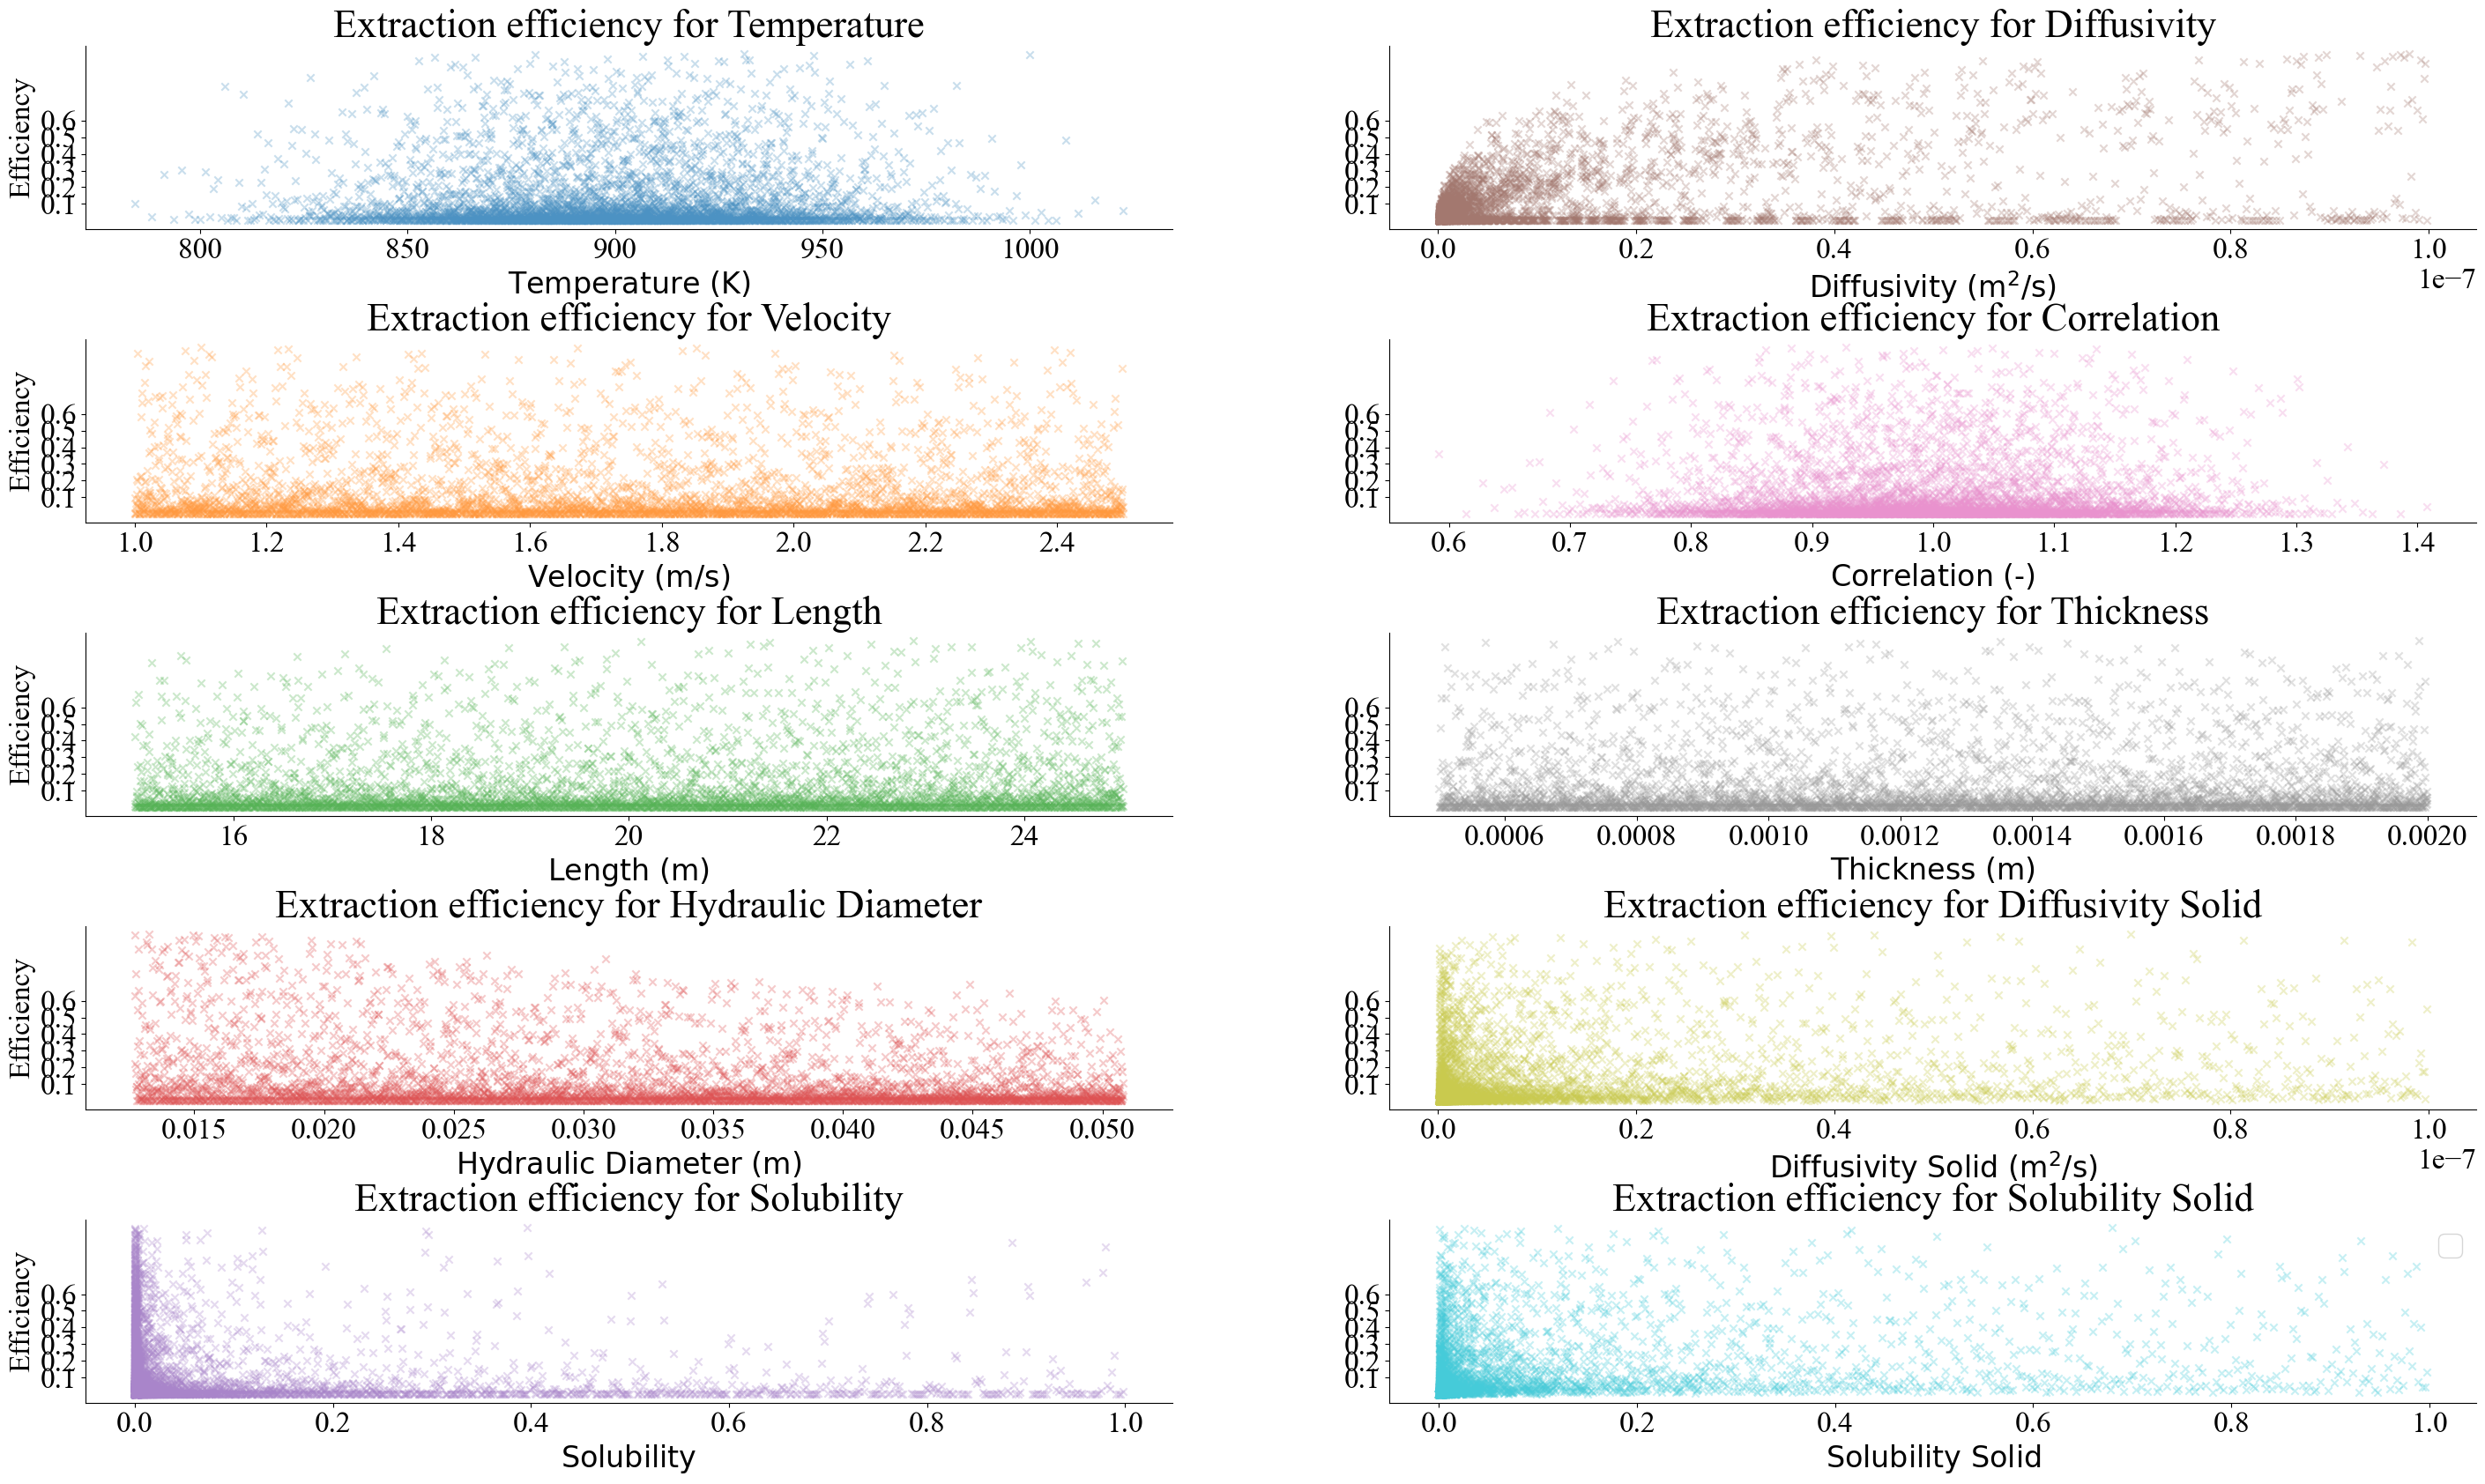

In [8]:
figure,ax=plt.subplots(len(sample_str)//2+len(sample_str)%2,2,figsize=(35,20))
for i in range(len(samples.T[0,:])):
    if i<len(sample_str)//2:
        # ax[i,0].scatter(samples.T[:,i], evaluations, alpha=0.3,color=colors[i], label="Smooth pipe")
        ax[i,0].scatter(samples.T[:,i], evaluations_wc, alpha=0.3,color=color_wc[i], marker="x", label="Wire coil")
        
        ax[i,0].set_xlabel(axis_str[i])
        ax[i,0].set_ylabel("Efficiency")
        # ax[0,i].set_xscale("log")
        # ax[0,i].set_yscale("log")
        ax[i,0].set_title("Extraction efficiency for " + title_str[i])
        ax[ i,0].spines['right'].set_visible(False)
        ax[ i,0].spines['top'].set_visible(False)
        ax[i,0].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
    else:
        # ax[i-len(sample_str)//2,1].scatter(samples.T[:,i], evaluations, alpha=0.3,color=colors[i])
        ax[i-len(sample_str)//2,1].scatter(samples.T[:,i], evaluations_wc, alpha=0.3,color=color_wc[i], marker="x")
        
        ax[i-len(sample_str)//2,1].set_xlabel(axis_str[i])
        # ax[1,i-len(sample_str)//2].set_xscale("log")
        # ax[1,i-len(sample_str)//2].set_yscale("log")
        ax[i-len(sample_str)//2,1].set_title("Extraction efficiency for " + title_str[i])
        ax[ i - len(sample_str) // 2,1].spines['right'].set_visible(False)
        ax[ i - len(sample_str) // 2,1].spines['top'].set_visible(False)
        ax[ i - len(sample_str) // 2,1].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
plt.subplots_adjust(hspace=0.6)
plt.legend()
plt.show()


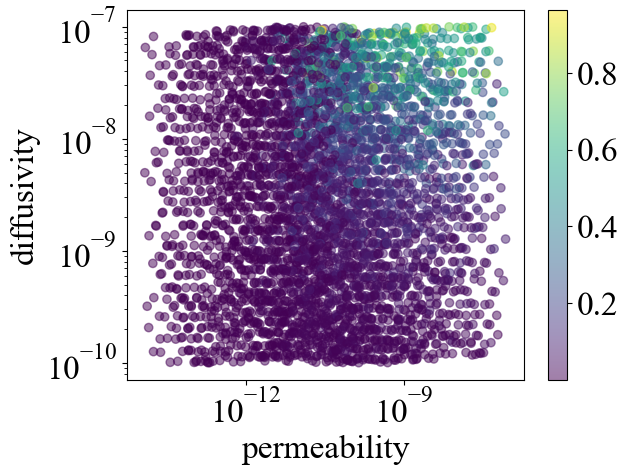

In [9]:
index_DL = sample_str.index("D_L")
index_DS = sample_str.index("D_S")
index_KS = sample_str.index("K_S_S")
plt.scatter(samples.T[:,index_DS]*samples.T[:,index_KS], samples.T[:,index_DL], c=evaluations, cmap='viridis', alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("permeability")
plt.ylabel("diffusivity")
plt.colorbar()  # To show the color scale

Plot PDF for input parameters

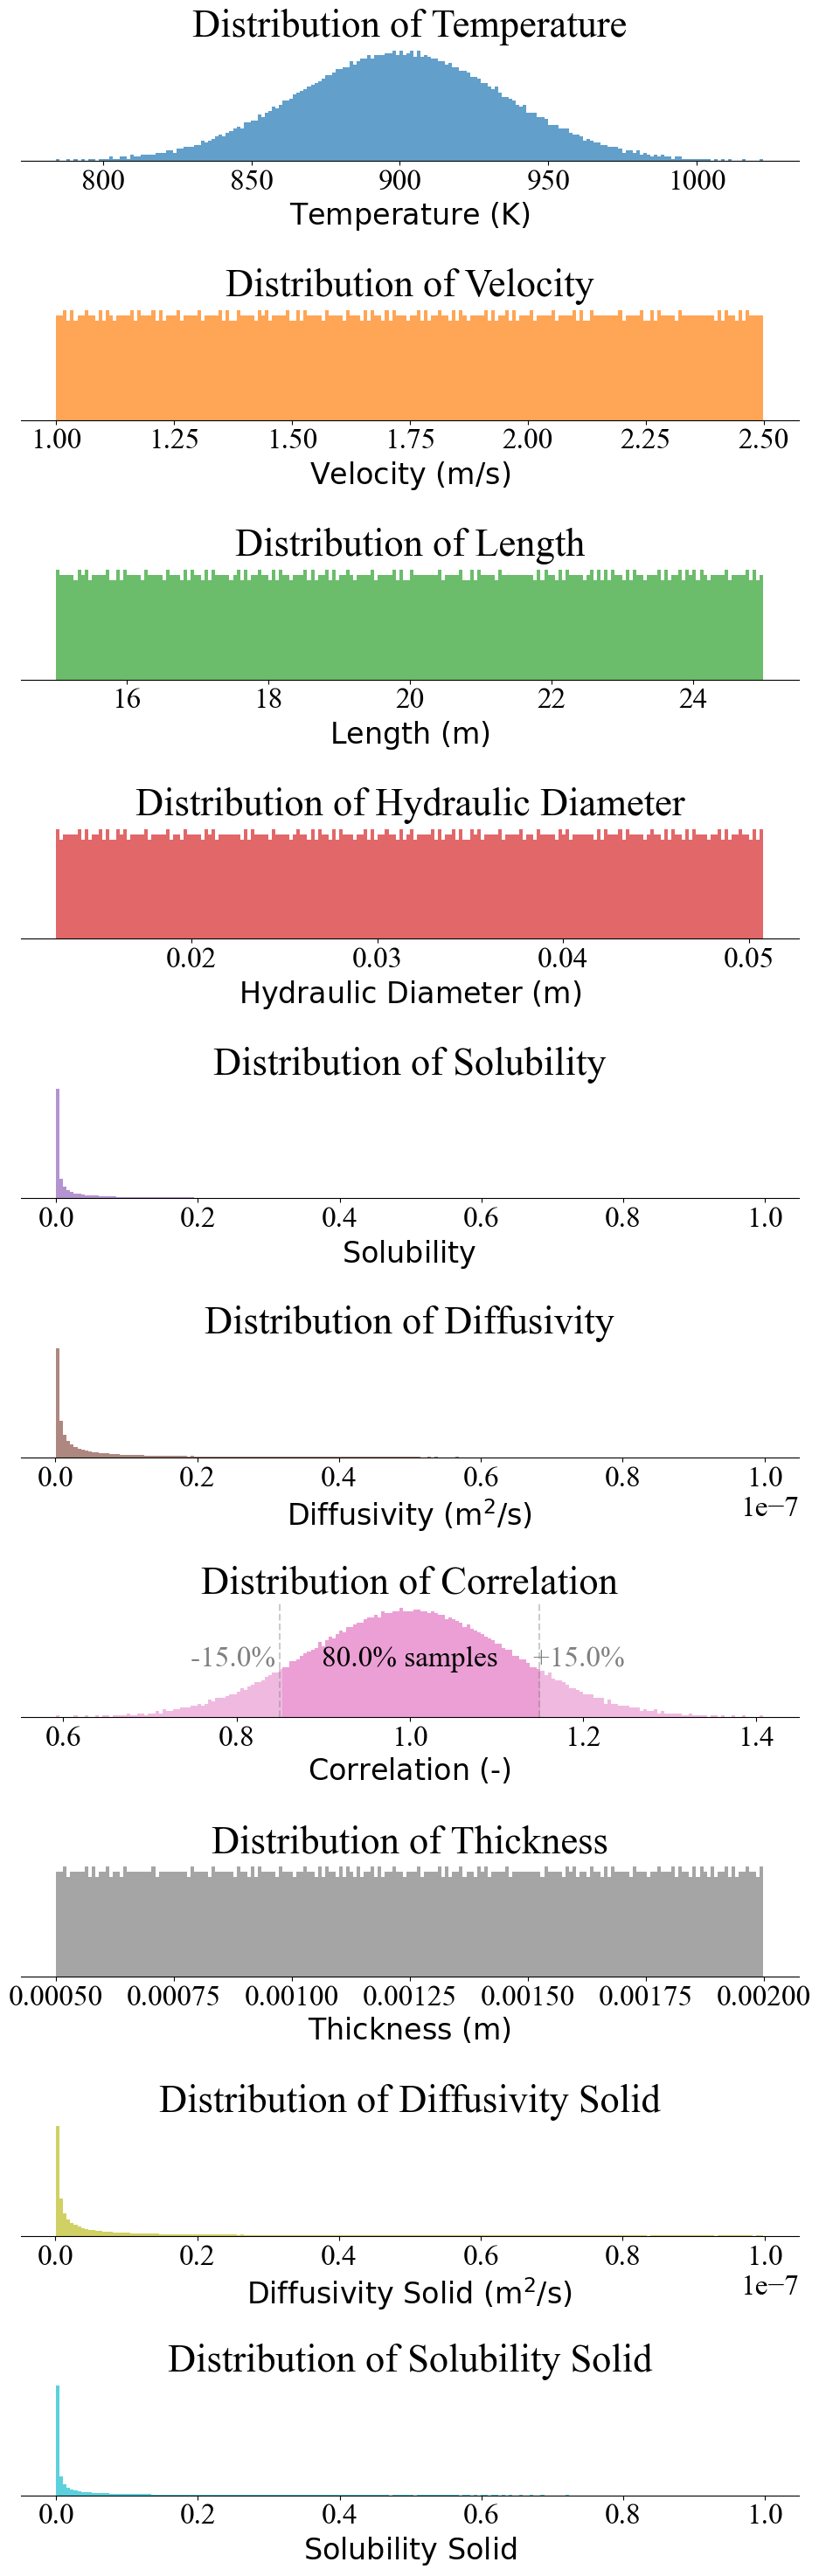

In [10]:
num_variables = len(sample_str)  # Number of variables (columns in samples)
fig, axs = plt.subplots(num_variables, 1, figsize=(10, num_variables * 3))
filter_i=[6]
for i in range(num_variables):
    # Calculate the average and the 10% range
    avg = samples[i, :].mean()
    lower_bound = avg * (1-percentage_within_mean)
    upper_bound = avg * (1+percentage_within_mean)

    # Plot the histogram
    n, bins, patches = axs[i].hist(samples[i, :], bins=200, alpha=0.7, color=colors[i])

    # Change alpha for bars outside the 10% range
    

    # Add horizontal lines at ±10% of the average
    if i in filter_i:
        for patch, bin_left in zip(patches, bins[:-1]):
            if bin_left < lower_bound or bin_left > upper_bound:
                patch.set_alpha(0.5)
        axs[i].axvline(x=lower_bound, color='grey', linestyle='--',alpha=0.4)
        axs[i].axvline(x=upper_bound, color='grey', linestyle='--',alpha=0.4)

        # Add text in the middle of the horizontal lines
        axs[i].text(avg, axs[i].get_ylim()[1] * 0.5, f'{confidence_level*100}% samples', ha='center', va='center', color='black')
        axs[i].text(avg* (1+percentage_within_mean+0.05), axs[i].get_ylim()[1]*0.5 , f'+{percentage_within_mean*100:.1f}% ', ha='center', va='center', color='gray')
        axs[i].text(avg* (1-percentage_within_mean-0.05), axs[i].get_ylim()[1]*0.5 , f'-{percentage_within_mean*100:.1f}% ', ha='center', va='center', color='gray')
        
    # Set titles and labels
    axs[i].set_title(f'Distribution of {title_str[i]}')
    axs[i].set_xlabel(axis_str[i])
    axs[i].set_ylabel('probability')
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_yticks([])
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

Plot PDF for evaluations

99.99999999999999


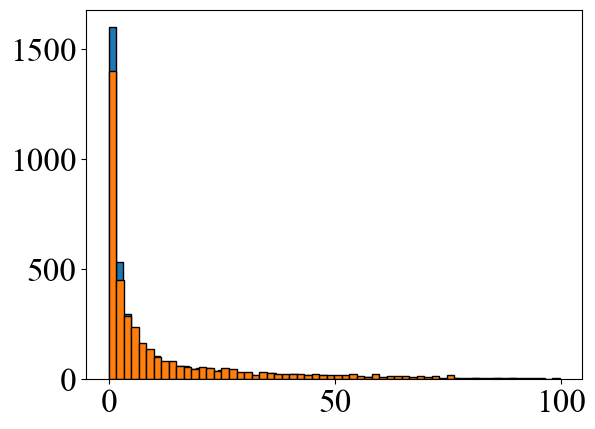

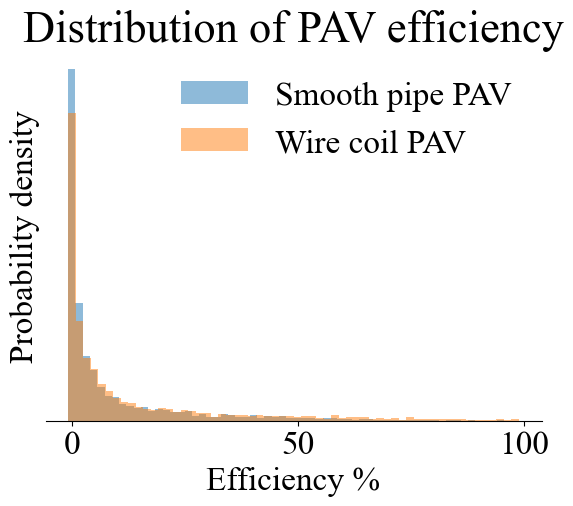

In [11]:
N_h, bins, patches = plt.hist(evaluations*100, bins=60, edgecolor='black')

# Normalize the histogram
N_normalized = N_h / (len(evaluations) / 100)

N_h_wc, bins_wc, patches_wc = plt.hist(evaluations_wc*100, bins=60, edgecolor='black')
N_normalized_wc = N_h_wc / (len(evaluations_wc) / 100)
# Plot normalized histogram
plt.figure()
plt.bar(bins[:-1], N_h, width=np.diff(bins), alpha=0.5, label='Smooth pipe PAV')
plt.bar(bins_wc[:-1], N_h_wc, width=np.diff(bins_wc), alpha=0.5, label= 'Wire coil PAV')
plt.title('Distribution of PAV efficiency')
plt.xlabel('Efficiency %')
plt.ylabel('Probability density')
plt.legend(frameon=False)
plt.gca().set_yticks([])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

print(sum (N_normalized))


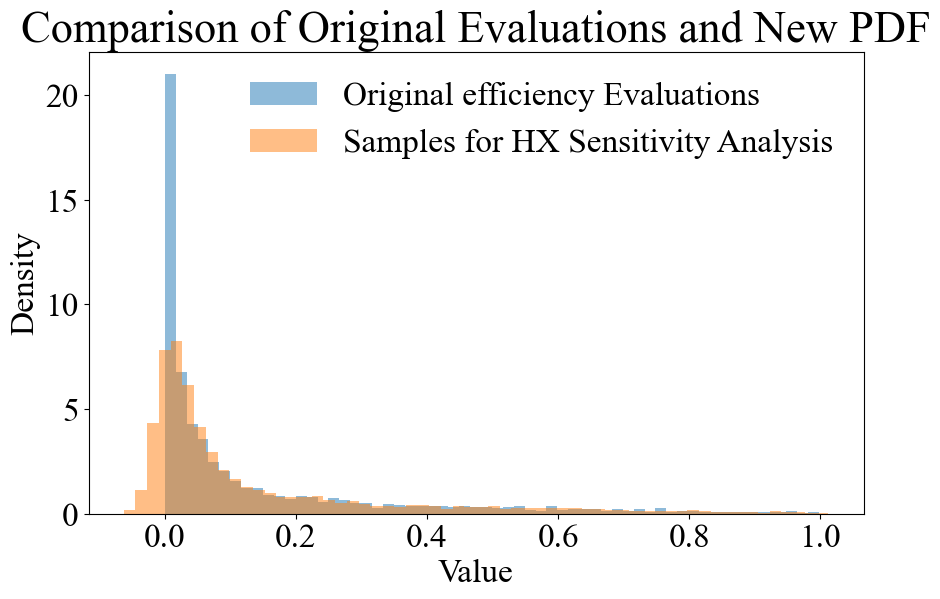

In [12]:

# Assuming evaluations is already defined
# Step 1: Estimate the PDF using KDE
# kde = stats.gaussian_kde(evaluations)
kde=cp.GaussianKDE(evaluations_wc, h_mat=0.02**2)
# Step 2: Generate new samples from the estimated PDF
num_new_samples = 10000  # Number of new samples for sensitivity analysis
new_samples = kde.sample(num_new_samples)

# Plot the original evaluations and the new samples for comparison
plt.figure(figsize=(10, 6))
plt.hist(evaluations_wc, bins=60, density=True, alpha=0.5, label='Original efficiency Evaluations')
plt.hist(new_samples.T, bins=60, density=True, alpha=0.5, label='Samples for HX Sensitivity Analysis')
plt.title('Comparison of Original Evaluations and New PDF')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(frameon=False)
plt.show()

# Now you can use new_samples for your new sensitivity analysis

Plot Sobol sensitivity Index 

In [13]:
# from cProfile import label
# selected_indices = [0,1, 2, 4]  # Indices of the elements you want to select
# selected_joint = joint[selected_indices]
# color_index = [colors[i] for i in selected_indices]
# title_index = [title_str[i] for i in selected_indices]
# sens=cp.Sens_t(approx_solver,joint)
# bars=plt.bar(height=sens.T, x=range(len(sens.T)),label=title_index,color=color_index)
# for bar, label in zip(bars, title_index):
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, 0.5, label, ha='center', va='center', color='black',rotation=90)
# ax = plt.gca()
# ax.set_xticklabels([])
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# print(sum(sens.T))
# plt.show()

In [14]:
def model_solver_HX(PAV,HX,BB,c0,recirculation,flag_wc=0):
    n_pipes_HX=2000
    i=0
    err=1
    c_in=c0
    
    tol=1E-6
    while err>tol:
        i=i+1
        
        err2=1
        tol2=1E-6
        j=0
        while err2>tol2:
            j=j+1
            c_in1=c_in
            PAV.update_attribute("c_in",c_in)    
            
            PAV.outlet_c_comp()
            c_in=(PAV.c_out*recirculation+BB.c_out)/(recirculation+1)
            err2=abs((c_in-c_in1)/c_in)
        HX.update_attribute("c_in",PAV.c_out)
        HX.get_global_HX_coeff(0)
        if flag_wc==1:
            R_cond = np.log((HX.fluid.d_Hyd + HX.membrane.thick) / HX.fluid.d_Hyd) / (
                2 * np.pi * HX.membrane.k
            )
            Re = corr.Re(HX.fluid.rho, HX.fluid.U0, HX.fluid.d_Hyd, HX.fluid.mu)
            Pr = corr.Pr(HX.fluid.cp, HX.fluid.mu, HX.fluid.k)
            Nu_wc=0.132*Re**0.72*Pr**0.37*(3)**-0.372
            h_prim = corr.get_h_from_Nu(
                Nu_wc, HX.fluid.k, HX.fluid.d_Hyd
            )
            HX.fluid.h_coeff = h_prim
            R_conv_prim = 1 / h_prim
            R_tot = R_conv_prim + R_cond 
            HX.U = 1 / R_tot
        L_HX=corr.get_length_HX(deltaTML=(corr.get_deltaTML(BB.T_out, BB.T_in,581, 800)), d_hyd=HX.fluid.d_Hyd, U=HX.U, Q=BB.Q/n_pipes_HX)
        HX.update_attribute("L",L_HX)
        HX.use_analytical_efficiency()
        HX.outlet_c_comp()
        
        err=abs((HX.c_out-BB.c_in)/HX.c_out)
        BB.update_attribute("c_in",HX.c_out)
        BB.get_cout()
    return 
def component_builder_HX(samples, sample_str,flag_wc=0):
    d_hyd=25.4E-3
    T=900
    L=20
    U0=1.5
    c0=1E-3
    mat=materials.Flibe(T)
    rho_flibe=2415.6-0.49072*T
    mu_flibe=1.16E-4*np.exp(3755/T)
    k_H=8.27E-9*np.exp(4.27E-3*T)
    D_flibe=9.3E-7*np.exp((-42E3)/(R*T))
    K_S_S=953*np.exp((-10.7E3)/(R*T))*1E-3
    k_b_const=8.617E-5
    D_S_PAV=5.6E-8*np.exp((-0.09)/(k_b_const*T))
    N_A_const=6.022E23
    K_S_PAV=8.31E22/N_A_const*np.exp((0.3)/(k_b_const*T))
    D_Steel=4.17E-8*np.exp((-0.12)/(8.617E-5*T))
    recirculation=0
    n_pipes_HX=2000
    flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=U0*(recirculation+1),k=mat.k,
        cp=mat.cp)
    Vanadium = Membrane( T=T,
            D=D_S_PAV,
            thick=0.5E-3,
            K_S=K_S_PAV,
            k_d=1E6,
            k_r=1E6,k=21)
    PAV_geometry=Geometry(D=d_hyd,L=L,thick=0.25E-3)
    c_in=c0
    BB=BreedingBlanket(Q=0.625E9,TBR=1.08,T_in=800,T_out=T,c_in=0, fluid=flibe)
    BB.get_flowrate()
    BB.get_cout()
    c0=BB.c_out
    PAV = Component(c_in=c_in,geometry=PAV_geometry, fluid=flibe, membrane=Vanadium)
    mat_HX=materials.Flibe((BB.T_in+BB.T_out)/2)
    d_hyd_HX=50E-3
    U0_HX=BB.m_coolant/(mat_HX.rho*np.pi*d_hyd_HX**2/4*n_pipes_HX)
    flibe_HX=Fluid(T=(BB.T_in+BB.T_out)/2, Solubility=mat_HX.Solubility, MS=True,D=mat_HX.D, d_Hyd=d_hyd_HX ,mu=mat_HX.mu,U0=U0_HX,rho=mat_HX.rho,k=mat.k,cp=mat_HX.cp)
    geometry_HX=Geometry(D=d_hyd_HX,L=L,thick=1E-3)
    Steel_HX = Membrane( T=T,
            D=D_Steel,
            thick=1E-3,
            K_S=K_S_S,
            k_d=1E6,
            k_r=1E6,k=21)
    HX = Component(c_in=c_in,geometry=geometry_HX, fluid=flibe_HX, membrane=Steel_HX)
    
    for i,sample in enumerate(samples):
        if sample_str[i]=="D_L":
            
            HX.fluid.update_attribute("D",sample)
        elif sample_str[i]=="PAV_eff":
            if sample>=0.85:
                sample=0.85 ## Kde can fit to unphysical efficiencies
            if sample <=0.05:
                sample=0.05
            PAV.update_attribute("eff",sample)
        elif sample_str[i]=="D_S":
            
            HX.membrane.update_attribute("D",sample*np.exp(0.12/(8.617E-5*T)))
        elif sample_str[i]=="U0":
            
            HX.fluid.update_attribute("U0",sample*(recirculation+1))
        elif sample_str[i]=="K_S":
            HX.membrane.update_attribute("K_S",sample*np.exp(10.7E3/(R*T)))
        elif sample_str[i]=="corr":
                HX.fluid.get_kt()
                HX.fluid.update_attribute("k_t",sample*HX.fluid.k_t*sample)
        else:
            HX.update_attribute(sample_str[i],sample)
    if flag_wc==1:
        Re=corr.Re(rho=HX.fluid.rho, u=HX.fluid.U0, L=HX.fluid.d_Hyd, mu=HX.fluid.mu)
        Sc=corr.Schmidt(D=HX.fluid.D, mu=HX.fluid.mu, rho=HX.fluid.rho)
        Sh_wc=0.132*Re**0.72*Sc**0.37*(3)**-0.372
        k_t_wc=corr.get_k_from_Sh(Sh_wc, L=HX.fluid.d_Hyd,
                    D=HX.fluid.D,)
        HX.update_attribute("k_t",k_t_wc)
    model_solver_HX(PAV,HX,BB,c0,recirculation,1)
    n_pipes_HX=BB.m_coolant/(mat_HX.rho*np.pi*d_hyd_HX**2/4*HX.fluid.U0)
    return ((HX.c_in-HX.c_out)*HX.fluid.U0*HX.fluid.d_Hyd**2/4*n_pipes_HX)/tritium_gen/TBR
    

In [17]:
N=1E3 # number of evaluations
# Define mean values for the uncertain variables
T_mean=900
U0_mean=1.75
L_mean=20
d_hyd_mean=2.54E-2
k_H_mean=8.27E-9*np.exp(4.27E-3*T_mean)
D_flibe_mean=9.3E-7*np.exp((-42E3)/(R*T_mean))
corr_correction_mean=1
thick_mean=1E-3

# define probability distributions for the uncertain variables
K_S_mean=10**(-1)
T=cp.Normal(mu=T_mean,sigma=percentage_within_mean * 300 / z_score)
# U0=cp.Normal(mu=U0_mean,sigma=percentage_within_mean * U0_mean / z_score)
U0=cp.Uniform(1,2.5)
# d_hyd=cp.Normal(mu=d_hyd_mean,sigma=percentage_within_mean * d_hyd_mean / z_score)
d_hyd=cp.Uniform(2.54E-2/2,2.54E-2*1.5)
k_H=10**cp.Uniform(-4,0)
D_flibe=10**(cp.Uniform(-9,-7))
D_S_0=10**(cp.Uniform(-10,-8))
Solubility_0=10**(cp.Uniform(-3,0))
# k_H = cp.Normal(mu=k_H_mean, sigma=(percentage_within_mean *k_H_mean / z_score))
# D_flibe=cp.Normal(mu=D_flibe_mean, sigma=(percentage_within_mean * D_flibe_mean / z_score))
corr_correction=cp.Normal(mu=corr_correction_mean,sigma=percentage_within_mean_corr * corr_correction_mean / z_score_corr)
# thick=cp.Normal(mu=thick_mean,sigma=percentage_within_mean * thick_mean / z_score)
thick=cp.Uniform(1E-3,4E-3)
K_S=cp.Normal(mu=K_S_mean,sigma=percentage_within_mean * K_S_mean / z_score)
#Solubility vanadium
# D_S_0=10**(cp.Uniform(-13,-8))
# D_S_0=cp.Normal(mu=4.17E-8,sigma=percentage_within_mean * 4.17E-8 / z_score)
# Solubility_0=cp.Uniform(1E-3,2E-3)
# Solubility_0=cp.Normal(mu=953E-3,sigma=percentage_within_mean * 953E-3 / z_score)


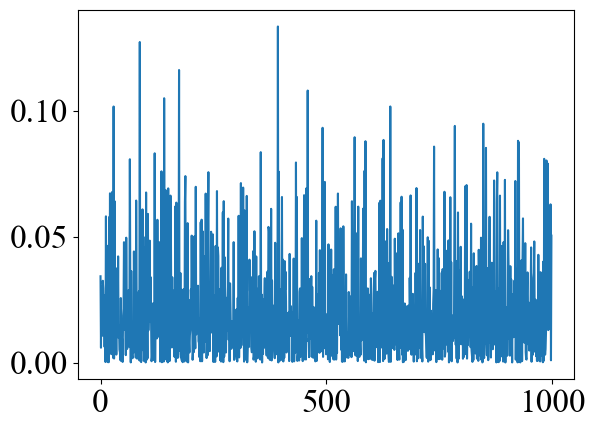

In [18]:
joint=cp.J(T,U0,d_hyd,k_H,D_flibe,corr_correction,thick,D_S_0,Solubility_0,kde)
# joint=cp.J(T,U0,d_hyd,k_H,D_flibe,thick,D_S_0,Solubility_0,kde)
expansion=cp.generate_expansion(3,joint)
samples=joint.sample(N,rule="sobol")
# samples = np.concatenate((samples, new_samples), axis=0)

flag=1
sample_str=["T","U0","d_Hyd","Solubility","D_L","corr","thick","D_S","K_S","PAV_eff"]
# sample_str=["T","U0","d_Hyd","Solubility","D_L","thick","D_S","K_S","PAV_eff"]
title_str=["Temperature","Velocity","Hydraulic Diameter","Solubility","Liquid Diffusivity","Correlation","Thickness","Solid Diffusivity","Solid Solubility","PAV_eff"]

evaluations = np.array([component_builder_HX(sample,sample_str) for sample in samples.T])
evaluations_wc=np.array([component_builder_HX(sample,sample_str,1) for sample in samples.T])
plt.plot(evaluations.T)



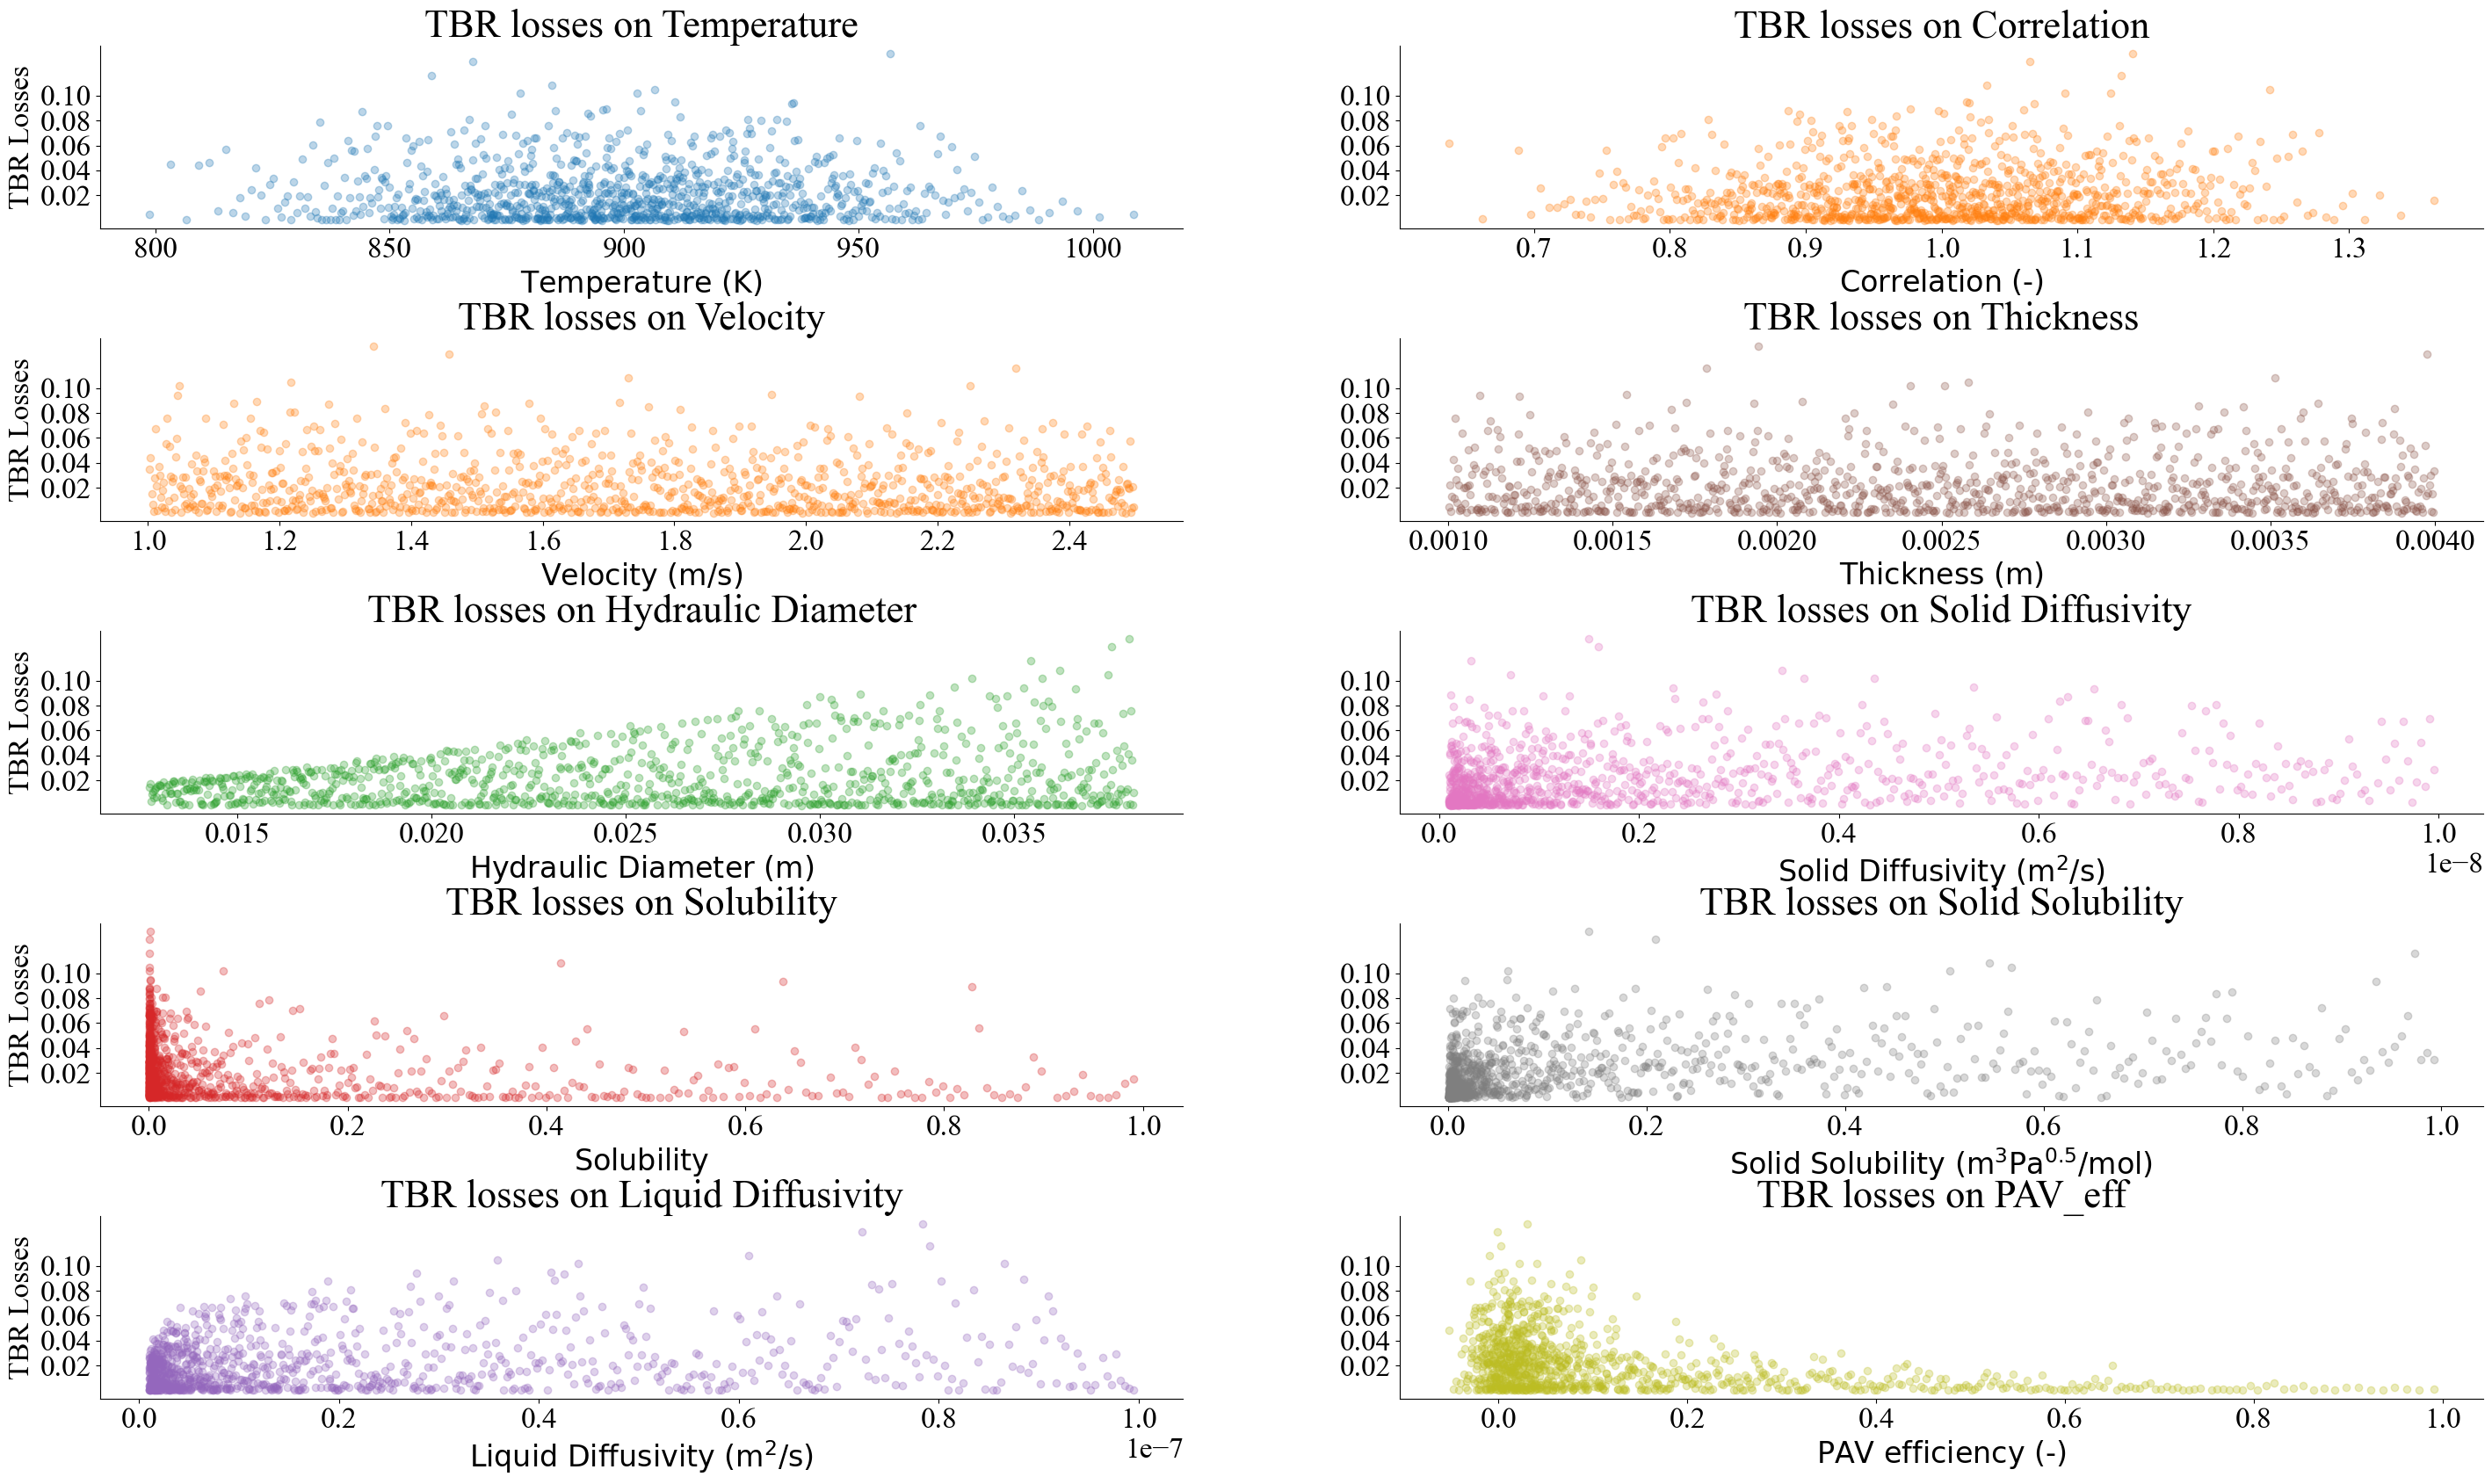

In [19]:
axis_str = [
    r"$\text{Temperature (K)}$",
    r"$\text{Velocity (m/s)}$",
    r"$\text{Hydraulic Diameter (m)}$",
    r"$\text{Solubility}$",
    r"$\text{Liquid Diffusivity (m}^2\text{/s)}$",
    r"$\text{Correlation (-)}$",
    r"$\text{Thickness (m)}$",
    r"$\text{Solid Diffusivity (m}^2\text{/s)}$",
    r"$\text{Solid Solubility (m}^3 \text{Pa}^{0.5}\text{/mol})$",
    r"$\text{PAV efficiency (-)}$"
]
colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#ff7f0e",  # Orange
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Yellow-green
    "#17becf",  # Cyan
    "#ff1493",  # Deep Pink
    "#00ff00"   # Lime
]

figure,ax=plt.subplots(len(sample_str)//2+len(sample_str)%2,2,figsize=(35,20))
for i in range(len(samples.T[0,:])):
    if i<len(sample_str)//2:
        ax[i,0].scatter(samples.T[:,i], evaluations, alpha=0.3,color=colors[i])
        # ax[i,0].scatter(samples.T[:,i], evaluations_wc, alpha=0.3,color=color_wc[i], marker="x")
        ax[i,0].set_xlabel(axis_str[i])
        ax[i,0].set_ylabel("TBR Losses")
        # ax[0,i].set_xscale("log")
        # ax[0,i].set_yscale("log")
        ax[i,0].set_title("TBR losses on " + title_str[i])
        ax[ i,0].spines['right'].set_visible(False)
        ax[ i,0].spines['top'].set_visible(False)
        ax[i,0].set_yticks([0.02,0.04,0.06,0.08,0.1])
    else:
        ax[i-len(sample_str)//2,1].scatter(samples.T[:,i], evaluations, alpha=0.3,color=colors[i])
        # ax[i-len(sample_str)//2,1].scatter(samples.T[:,i], evaluations_wc, alpha=0.3,color=color_wc[i], marker="x")
        ax[i-len(sample_str)//2,1].set_xlabel(axis_str[i])
        # ax[i-len(sample_str)//2,1].set_xscale("log")
        # ax[1,i-len(sample_str)//2].set_yscale("log")
        ax[i-len(sample_str)//2,1].set_title("TBR losses on " + title_str[i])
        ax[ i - len(sample_str) // 2,1].spines['right'].set_visible(False)
        ax[ i - len(sample_str) // 2,1].spines['top'].set_visible(False)
        ax[ i - len(sample_str) // 2,1].set_yticks([0.02,0.04,0.06,0.08,0.1])
plt.subplots_adjust(hspace=0.6)
plt.show()


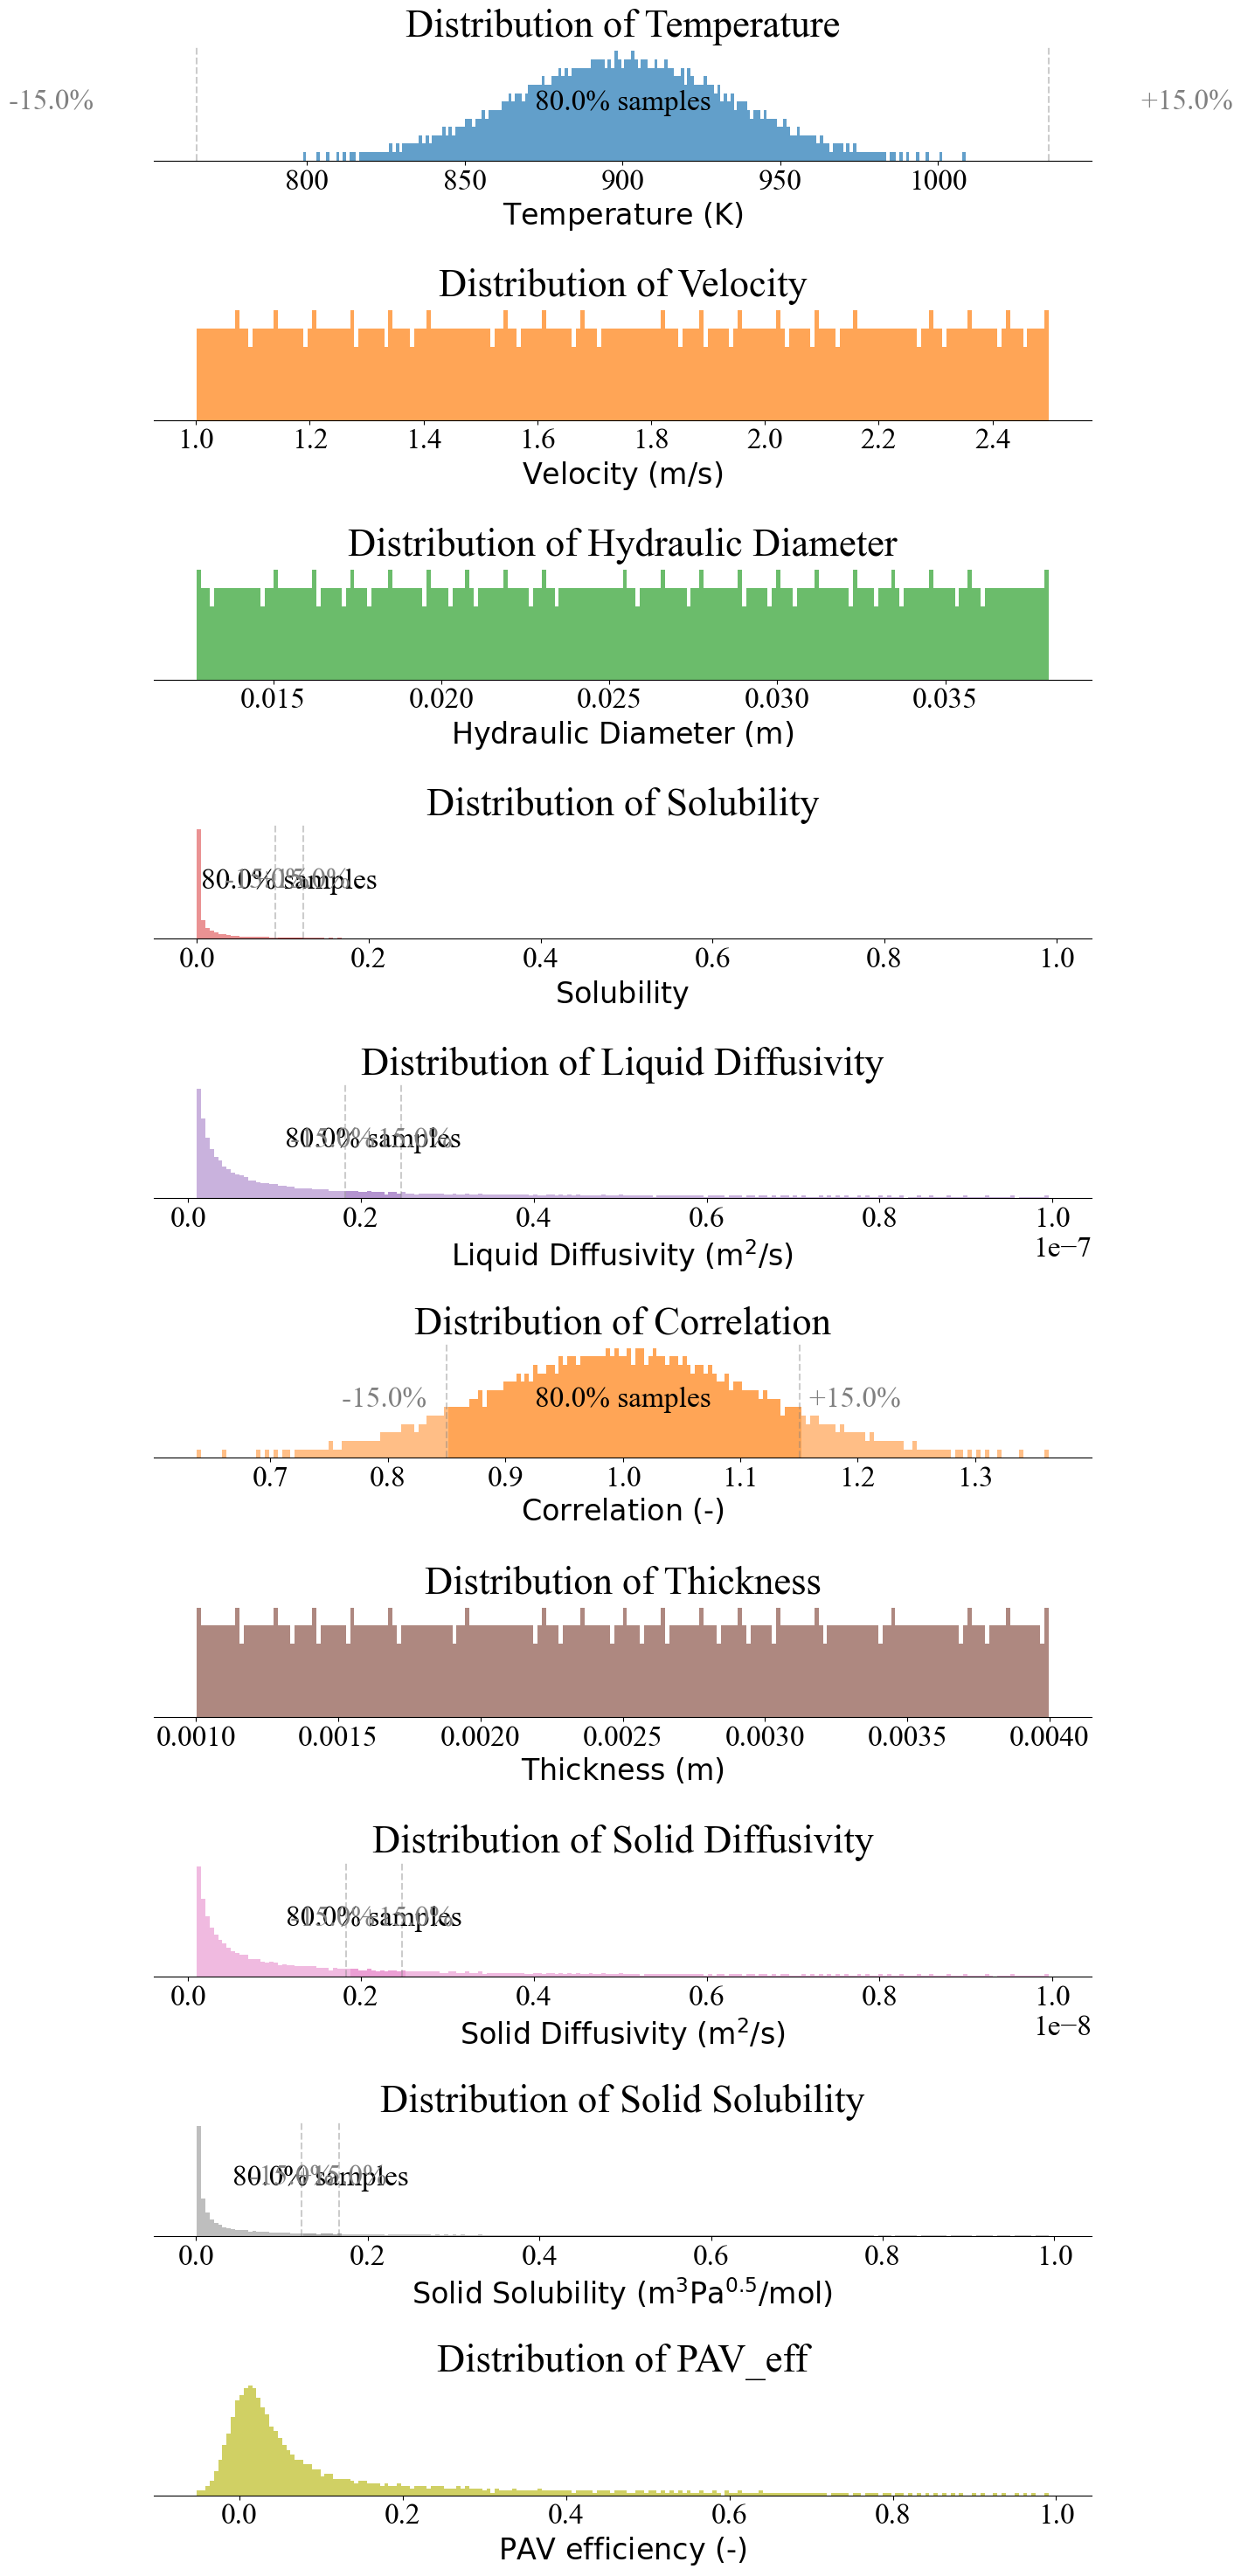

In [20]:

num_variables = len(sample_str)  # Number of variables (columns in samples)
fig, axs = plt.subplots(num_variables, 1, figsize=(15, num_variables * 3))
filter_i=[0,3,4,5,7,8]
for i in range(num_variables):
    # Calculate the average and the 10% range
    avg = samples[i, :].mean()
    lower_bound = avg * (1-percentage_within_mean)
    upper_bound = avg * (1+percentage_within_mean)

    # Plot the histogram
    n, bins, patches = axs[i].hist(samples[i, :], bins=200, alpha=0.7, color=colors[i])

    # Change alpha for bars outside the 10% range
    

    # Add horizontal lines at ±10% of the average
    if i in filter_i:
        for patch, bin_left in zip(patches, bins[:-1]):
            if bin_left < lower_bound or bin_left > upper_bound:
                patch.set_alpha(0.5)
        axs[i].axvline(x=lower_bound, color='grey', linestyle='--',alpha=0.4)
        axs[i].axvline(x=upper_bound, color='grey', linestyle='--',alpha=0.4)

        # Add text in the middle of the horizontal lines
        axs[i].text(avg, axs[i].get_ylim()[1] * 0.5, f'{confidence_level*100}% samples', ha='center', va='center', color='black')
        axs[i].text(avg* (1+percentage_within_mean+0.05), axs[i].get_ylim()[1]*0.5 , f'+{percentage_within_mean*100:.1f}% ', ha='center', va='center', color='gray')
        axs[i].text(avg* (1-percentage_within_mean-0.05), axs[i].get_ylim()[1]*0.5 , f'-{percentage_within_mean*100:.1f}% ', ha='center', va='center', color='gray')
        
    # Set titles and labels
    axs[i].set_title(f'Distribution of {title_str[i]}')
    axs[i].set_xlabel(axis_str[i])
    axs[i].set_ylabel('probability')
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_yticks([])
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

99.99999999999987


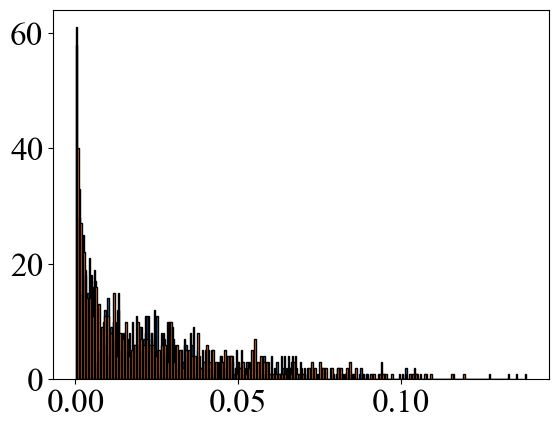

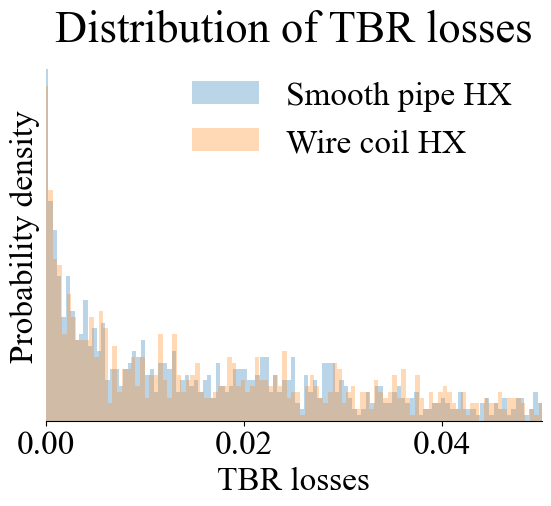

In [21]:
N_h, bins, patches = plt.hist(evaluations, bins=300, edgecolor='black')
N_h_wc, bins_wc, patches_wc = plt.hist(evaluations_wc, bins=300, edgecolor='black')

# Normalize the histogram
N_normalized = N_h / (len(evaluations) / 100)
N_normalized_wc = N_h_wc / (len(evaluations_wc) / 100)

# Plot normalized histogram
plt.figure()
plt.bar(bins[:-1], N_h, width=np.diff(bins),alpha=0.3, label="Smooth pipe HX")
plt.bar(bins_wc[:-1], N_h_wc, width=np.diff(bins_wc),alpha=0.3, label="Wire coil HX")
plt.title('Distribution of TBR losses')
plt.xlabel('TBR losses')
plt.legend(frameon=False)
plt.ylabel('Probability density')
plt.gca().set_yticks([])
plt.gca().set_xticks([0,0.02,0.04])
plt.gca().set_xlim([0.0,0.05])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

print(sum (N_normalized))

In [22]:
# from cProfile import label
# selected_indices = [0,1, 2, 3,4, 5,6]  # Indices of the elements you want to select
# selected_joint = joint[selected_indices]
# # selected_joint = joint
# color_index = [colors[i] for i in selected_indices]
# title_index = [title_str[i] for i in selected_indices]
# sens=cp.Sens_t(approx_solver,joint)
# bars=plt.bar(height=sens.T, x=range(len(sens.T)),label=title_index,color=color_index)
# for bar, label in zip(bars, title_index):
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, 0.5, label, ha='center', va='center', color='black',rotation=90)
# ax = plt.gca()
# ax.set_xticklabels([])
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# print(sum(sens.T))
# plt.show()